# Exercise 05:  Solving differential equation-based Bayesian inverse problems using CUQIpy

Here we build a Bayesian problem in which the forward model is a partial differential equation model, 1D Heat problem in particular.

## Learning objectives of this notebook:
- Solve PDE-based Bayesian problem using CUQIpy.
- Parametrization of the Bayesian parameters (e.g. KL expansion, non-linear maps).
- Introducing cuqi PDE class.

## Table of contents: 
* [1. Loading the PDE test problem](#PDE_model)
* [2. Building and solving the Bayesian inverse problem](#inverse_problem)
* [3. Parametrizing the Bayesian parameters to enforce positivity](#mapped_geometries)
* [4. (Optional) parametrizing the Bayesian parameters via step function expansion](#step_function)
* [5. (Optional) elaboration: the PDEmodel class](#PDE_model_elaborate)


##  1. Loading the PDE test problem <a class="anchor" id="PDE_model"></a>

We first import the required python standard packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from math import floor, ceil

%load_ext autoreload
%autoreload 2

From cuqi package, we import the classes that we use in this exercise

In [2]:
from cuqi.geometry import Continuous1D, MappedGeometry, KLExpansion
from cuqi.pde import SteadyStateLinearPDE
from cuqi.model import PDEModel
from cuqi.distribution import GaussianCov, Posterior, Gaussian
from cuqi.sampler import pCN
from cuqi.testproblem import Heat_1D
from cuqi.operator import FirstOrderFiniteDifference
from cuqi.pde import SteadyStateLinearPDE

We load the test problem `Heat_1D` which provides a one dimensional (1D) time dependent heat model with zero boundary conditions descritized using forward finite difference in space and forward Euler in time.

The PDE is given by:

$$ \frac{\partial u(x,t)}{\partial t} + c \Delta_x u(x,t)   = f(x,t), \;\text{in}\;\Omega=[0,L] $$
$$u(0,t)= u(L,t)= 0 $$

where $u(x,t)$ is the temprature and $c$ is the thermal difusivity. We assume the source term $f$ is zero. The unknown Bayesian parameters for this test problem is the initial heat profile $\theta(x)$. The data $\mathbf{d}$ are the temperature measurements everywhere in the domain at the final time $T$.

We load `Heat_1D` using `get_components` moethd. We can explore the initialization parameters (and hence what can be passed to `get_components` method) of the `Heat_1D` test problem by calling `Heat_1D?`. We choose the following set up for the test problem: Nubmer of finite difference nodes N, length of domian L and the final time T.

In [3]:
N = 20  # number of finite difference nodes            
L = 1    # Length of the domain
T = 0.05  # Final time

We choose the initial condition (the exact solution for this problem) to be a liner combination of three a step functions.

In [4]:
myExactSolution = np.zeros(N)
myExactSolution[:floor(N/3)] = 1
myExactSolution[floor(N/3):floor(2*N/3)] = 2
myExactSolution[floor(2*N/3):] = 3

And now we load the `Heat_1D` problem:

In [5]:
model, data, problemInfo = Heat_1D.get_components(dim=N, endpoint=L, max_time=T, exactSolution=myExactSolution)

Lets take a look at what we obtain from the test problem. We view the `model`:

In [6]:
model

cuqi PDEModel: Continuous1D(20,) -> Continuous1D(20,)

We can look at the data:

In [7]:
data

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Continuous1D(20,)

Parameters:
 True

Array:
CUQIarray([0.1613851 , 0.40304367, 0.59385808, 0.77569881, 1.01088703,
           1.16174711, 1.27381432, 1.456965  , 1.52850929, 1.55911268,
           1.60398058, 1.67484806, 1.57600548, 1.48319709, 1.35667555,
           1.24143594, 1.05081603, 0.74582743, 0.60157919, 0.29920343])

And the `problemInfo`:

In [8]:
problemInfo

ProblemInfo with the following set attributes:
['infoString', 'exactData', 'exactSolution']
 infoString: Noise type: Additive i.i.d. noise with mean zero and signal to noise ratio: 200

Now lets plot the exact solution of this inverse problem and the exact and noisy data

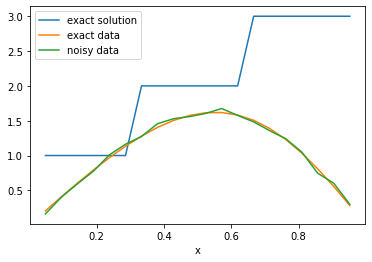

In [9]:
problemInfo.exactSolution.plot()
problemInfo.exactData.plot()
data.plot()
plt.legend(['exact solution', 'exact data', 'noisy data'])

## 2. Building and solving the Bayesian inverse problem <a class="anchor" id="inverse_problem"></a>

Here we want to define the prior, the likelihood and the posterior distribution. We start by defining a simple Gaussian prior.

In [10]:
mean = 0
std = 1.2
prior = Gaussian(mean*np.ones(N), std, geometry= model.domain_geometry)

***
#### Try yourself (optional)
* create prior samples (~1 line).
* plot the 95% confidence interval of the prior samples (~1 line).
* look at the 95% confidence interval of the PDE model solution to quantify the forward uncertainty (~2 lines).
***

We then set up the likelihood. We obtain information about the noise distribution from `problemInfo.infoString`:

In [11]:
problemInfo.infoString

'Noise type: Additive i.i.d. noise with mean zero and signal to noise ratio: 200'

We define the likelihood:

In [12]:
SNR = 200
sigma_likelihood = np.linalg.norm(problemInfo.exactData)/SNR
likelihood = Gaussian(mean=model, std=sigma_likelihood, corrmat=np.eye(N), geometry=model.range_geometry)

Now that we have all the components we need, we can create the posterior distribution:

In [13]:
posterior =  Posterior(likelihood, prior, data)

We can now sample the posterior. Lets try the preconditioned Crank-Nicolson (pCN) sampler:

In [14]:
MySampler = pCN(posterior,1)
posterior_samples = MySampler.sample_adapt(5000)

 Sample 5000 / 5000

Average acceptance rate: 0.0696 MCMC scale: 0.1552455713994743 



Let's look at the samples:

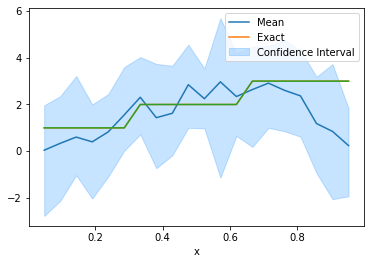

In [15]:
np.random.seed(0)
posterior_samples.plot_ci(98, exact = problemInfo.exactSolution)
problemInfo.exactSolution.plot()

We also can look at chains for particular parameters:

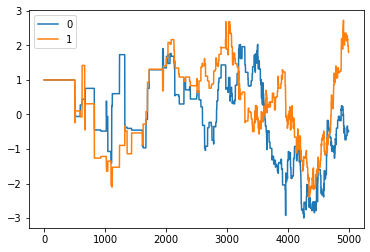

In [16]:
posterior_samples.plot_chain([0,1])

## 2 new (positivity)

In [17]:
model, data, problemInfo = Heat_1D.get_components(dim=N, endpoint=L, max_time=T, KL_map = lambda x : np.exp(x))
prior = Gaussian(mean*np.ones(N), std, geometry= model.domain_geometry)
likelihood = Gaussian(mean=model, std=sigma_likelihood, corrmat=np.eye(N), geometry=model.range_geometry)
posterior =  Posterior(likelihood, prior, data)
MySampler = pCN(posterior,1)
posterior_samples = MySampler.sample_adapt(5000)


 Sample 5000 / 5000

Average acceptance rate: 0.1316 MCMC scale: 0.19149304375766854 



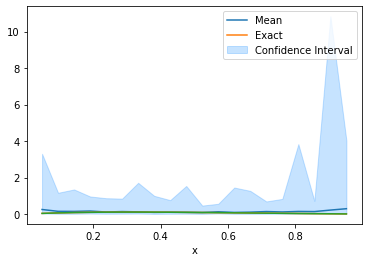

In [18]:
posterior_samples.plot_ci(98, exact = problemInfo.exactSolution)
problemInfo.exactSolution.plot()

## 3 new Step function

In [19]:
## 3 new KL function

In [20]:
np.random.seed(0)
N=20
model, data, problemInfo = Heat_1D.get_components(dim=N, endpoint=L, max_time=T,field_type='Step')
prior = Gaussian(mean*np.ones(3), std, geometry= model.domain_geometry)
likelihood = Gaussian(mean=model, std=sigma_likelihood, corrmat=np.eye(N), geometry=model.range_geometry)
posterior =  Posterior(likelihood, prior, data)
MySampler = pCN(posterior,1)
posterior_samples = MySampler.sample_adapt(5000)

 Sample 5000 / 5000

Average acceptance rate: 0.0308 MCMC scale: 0.13943957416377947 



(3, 5000)

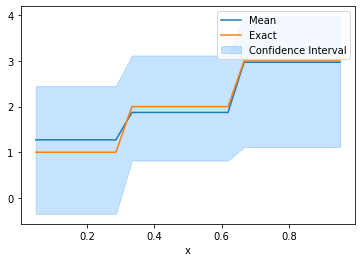

In [21]:
posterior_samples.plot_ci(98, exact = problemInfo.exactSolution)
posterior_samples.samples.shape

## 4 New

In [22]:
np.random.seed(0)
model, data, problemInfo = Heat_1D.get_components(dim=N, endpoint=L, max_time=T,field_type='Step', KL_map = lambda x:np.exp(x))
prior = Gaussian(mean*np.ones(3), std, geometry= model.domain_geometry)
likelihood = Gaussian(mean=model, std=sigma_likelihood, corrmat=np.eye(N), geometry=model.range_geometry)
posterior =  Posterior(likelihood, prior, data)
MySampler = pCN(posterior,1)
posterior_samples = MySampler.sample_adapt(5000)

 Sample 5000 / 5000

Average acceptance rate: 0.0106 MCMC scale: 0.1317838338683546 



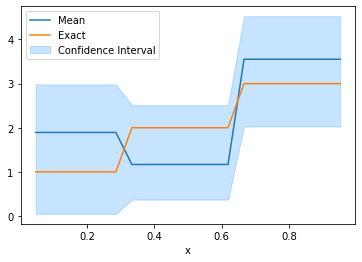

In [23]:
posterior_samples.plot_ci(98, exact = problemInfo.exactSolution)

## 5 New

In [24]:
np.random.seed(0)
model, data, problemInfo = Heat_1D.get_components(dim=N, endpoint=L, max_time=T, field_type = 'KL' )
var = 10
lc = 0.2
p = 2
C_YY = lambda x1, x2: var*np.exp( -(1/p) * (abs( x1 - x2 )/lc)**p )
x = model.domain_geometry.grid
XX, YY = np.meshgrid(x, x, indexing='ij')
sigma_prior = C_YY(XX, YY)
prior = GaussianCov(mean*np.ones(N), sigma_prior, geometry= model.domain_geometry)

likelihood = Gaussian(mean=model, std=sigma_likelihood, corrmat=np.eye(N), geometry=model.range_geometry)
posterior =  Posterior(likelihood, prior, data)
MySampler = pCN(posterior,1)
posterior_samples = MySampler.sample_adapt(10000)

 Sample 10000 / 10000

Average acceptance rate: 0.166 MCMC scale: 0.24273790278607338 



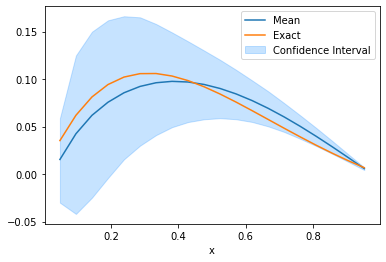

In [25]:
posterior_samples.plot_ci(100, exact = problemInfo.exactSolution)

## 3. Parametrizing the Bayesian parameters to enforce positivity <a class="anchor" id="mapped_geometries"></a> 

Here we introduce the concept of mapped geometries. In many inverse problems, parametrization of the forward model input through possibly nonlinear functions might be needed. For example, in this 1D heat example, we want to enforce positivity of the thermal conductivity. We can use the parametrization $c = e^\kappa$ where $c$ is the thermal conductivity and $\kappa$ is the Bayesian parameters (log thermal conductivity).  

In `CUQIpy`, this can be achieved through a `MappedGeometry` object. Lets update the exact solution, and the domain geometry and test this idea:  



In [26]:
mapped_exact_solution = np.log(problemInfo.exactSolution)
KL_geometry = model.domain_geometry
mapped_model = deepcopy(model)
mapped_model.domain_geometry = MappedGeometry(KL_geometry, map = lambda x : np.exp(x))

We, again, build the posterior distribution:

And sample:

Then plot the confidence interval:

## 4. (Optional) parametrizing the Bayesian parameters via step function expansion <a class="anchor" id="step_function"></a>

Here we explore a different parameterization, where the thermal conductivity is represented by a step function with 3 degrees of freedom. The code for this problem will look like:

In [28]:
step_model, step_data, step_problemInfo = Heat_1D.get_components(dim=N, endpoint=L, max_time=T, field_type = 'Step')
step_prior = Gaussian(np.ones(3),1, geometry = step_model.domain_geometry)
step_likelihood = Gaussian(mean=step_model, std=sigma_likelihood, corrmat=np.eye(N), geometry=model.range_geometry)
step_posterior =  Posterior(step_likelihood, step_prior, step_data)

Try it yourself:
* You can try to use pCN sampler to generate, lets say 10000, posterior sample and view the 100% confidence interval (~3 lines). Use sample_adapt.
* Try to enforce positivity of the posterior samples via the MappedGeometry and run the pCN sampler again (similar to part 3).

## 5. (Optional) elaboration: the PDEmodel class <a class="anchor" id="PDE_model_elaborate"></a>

Lets explore the model for PDE problems.

Try it yourself:

* View: `model`, `model.pde`, `model.pde.PDE_form`

We can create our own PDE model for simple Poisson equation with zero boundaries for example: 

In [29]:
n_poisson = 1000
L = 1
dx = L/(n_poisson-1)
diff_operator = FirstOrderFiniteDifference(n_poisson,bc_type='zero').get_matrix().todense()/dx
source_term = np.zeros(n_poisson)
source_term[int(n_poisson/2)] = 1/dx 

poisson_form = lambda x: (diff_operator.T@diff_operator, x* source_term)
CUQI_pde = SteadyStateLinearPDE(poisson_form)
CUQI_pde.assemble(5)
sol = CUQI_pde.solve()

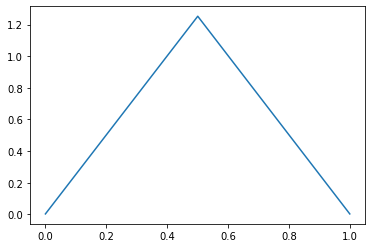

In [30]:
plt.plot(np.linspace(dx,L,n_poisson,endpoint=False),sol)

Try it yourself:

* Double the magnitude of the source term by editing the line `CUQI_pde.assemble(np.array([5]))` above. Look at the solution.